In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Have we got all the forcing we need?

Run plan from email:

    *notes from metoffice (TJ notes in italics):*

1. 1950 to 2100 using both SSP126 and SSP370 with standard UKESM1.0 : These runs are done, yes just need to provide the data.
    - *call SSP126 **1Fa** and SSP370 **1Fb***
2. 1950 to 2100 using both SSP126 and SSP370 each with ODS fixed at 1950 values
    - *call SSP126 **2Fa** and SSP370 **2Fb***
3. 1985 to 2100 using both SSP126 and SSP370 each with ODS fixed at 1985 values
    - *call SSP126 **3Fa** and SSP370 **3Fb***

       


### Match directories (under greenocean/software/resources/MetOffice) to scenarios 1-3, Historical and future A, B
### In each directory, check which data is present, check if files of size 0 are present
### Check which data we have symlinked

In [4]:
#root directory, where to find Met office files
tdir = '/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/'
dir_1H = 'hist/u-bc370_hist/'
dir_2H = 'hist/u-cj198_hist_1950start1950ozone/'
dir_3H = 'hist/u-cj200_hist_1990start1990ozone/'

dir_1FA = 'ssp126/u-be682_ssp126/'
dir_1FB = 'ssp370/u-ce417_ssp370/'

dir_2FA = 'ssp126/u-cj880_ssp126_1950start1950ozone/'
dir_2FB = 'ssp370/u-cj881_ssp370_1950start1950ozone/'

dir_3FA = 'ssp126/u-cj484_ssp126_1990start1990ozone/'
dir_3FB = 'ssp370/u-cj504_ssp370_1990start1990ozone/'

name_1H = '1H: NatlOzone-historical'
name_2H = '2H: Ozone1950-historical'
name_3H = '3H: Ozone1990-historical'
name_1FA = '1FA: NatlOzone-SSP126'
name_1FB = '1FB: NatlOzone-SSP370'
name_2FA = '2FA: Ozone1950-SSP126'
name_2FB = '2FB: Ozone1950-SSP370'
name_3FA = '3FA: Ozone1990-SSP126'
name_3FB = '3FB: Ozone1990-SSP370'

col_1A = 'darksalmon'; col_1B = 'sienna'
col_2A = 'lightgreen'; col_2B = 'g'
col_3A = 'dodgerblue'; col_3B = 'mediumblue'

exp_1H = 'bc370'; exp_2H = 'cj198'; exp_3H = 'cj200'
exp_1FA = 'be682'; exp_1FB = 'ce417'
exp_2FA = 'cj880'; exp_2FB = 'cj881'
exp_3FA = 'cj484'; exp_3FB = 'cj504'

In [39]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
from subprocess import check_output

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload

import matplotlib.path as mpath
import glob
import os

#rcparams
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}

In [6]:
def check_missing_data(yrstart, yrend, scen, desc,  tdir, tdir2, verbose = False):
    print(f'checking files for scenario {scen}, short description {desc}') 
    print(f'years for which we need forcing: {yrstart}-{yrend-1}')
    print(f'resource directory for this scenario is: {tdir}{tdir2}')
    yrs = []
    yrs_allgone = []    
    
    if (os.path.isdir(f'{tdir}{tdir2}') == False):
        print('Directory missing')
        dirmis = False
        
        yrs = np.arange(yrstart,yrend+1,1); yrs_allgone = np.arange(yrstart,yrend+1,1)
        print(f'(ie, yrs with files missing, scenario {scen}:)')
        print(yrs)
        print()
    else:
        dirmis = True
        strs = ['bulk','dust','rad','river','slp','wind']


        misfil = 'NO'
        com = f'find {tdir}{tdir2} -size 0'
        out = check_output([com], shell = True)
        siz_check = (len(out))
        if siz_check > 0:
            misfil = 'YES'
        print(f'files of size 0 present in directory? {misfil}')


        for y in range(yrstart,yrend):
            tyr = y

            yrstr = f'{tdir}{tdir2}*_y{y}*.nc'
            twfy = glob.glob(yrstr)
            nofilfy = len(twfy)

            if (nofilfy == 0):
                if verbose:
                    print(f'ALLGONEFORTHISYEAR!! {tyr}')
                yrs_allgone.append(tyr)
                yrs.append(tyr)    

            else:
                for s in range(0,len(strs)):

                    tch = f'{tdir}{tdir2}*{strs[s]}_y{y}*.nc'

                    tw = glob.glob(tch)
                    nofil = len(tw)
                    if (strs[s]=='slp') & (nofil != 4):
                        if verbose:
                            print(f'MISSING FILES! year: {tyr}, vartype: {strs[s]}')
                        # print('files available for this year and vartype:')
                        # print(tw)
                        if tyr not in yrs:
                            yrs.append(tyr)
                    elif ((strs[s]!='slp') &(nofil != 12)):
                        if verbose:
                            print(f'MISSING FILES! year: {tyr}, vartype: {strs[s]}')
                        # print('files available for this year and vartype:')
                        # print(tw)
                #cj198_wind_y1980
                        if tyr not in yrs:
                            yrs.append(tyr)
        if len(yrs) == 0:
            print('Directory complete (if no files of size 0 present)')
        else: 
            print(f'yrs with files missing, scenario {scen}:')
            print(yrs)
        print()
    
    return yrs, yrs_allgone, dirmis

## Historical scenarios 



In [7]:
yrstart = 1940; yrend = 2015
scen = '1H'
tdir2 = dir_1H; desc = name_1H
yrs, yrs_allgone, dirmis_1H = check_missing_data(yrstart, yrend, scen, desc, tdir, tdir2)
yrsmissing_1H = yrs

yrstart = 1950; yrend = 2015
scen = '2H'
tdir2 = dir_2H; desc = name_2H
yrs, yrs_allgone, dirmis_2H = check_missing_data(yrstart, yrend, scen, desc, tdir, tdir2)
yrsmissing_2H = yrs


yrstart = 1990; yrend = 2015
scen = '3H'
tdir2 = dir_3H; desc = name_3H
yrs, yrs_allgone, dirmis_3H = check_missing_data(yrstart, yrend, scen, desc, tdir, tdir2)
yrsmissing_3H = yrs



checking files for scenario 1H, short description 1H: NatlOzone-historical
years for which we need forcing: 1940-2014
resource directory for this scenario is: /gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/
files of size 0 present in directory? YES
Directory complete (if no files of size 0 present)

checking files for scenario 2H, short description 2H: Ozone1950-historical
years for which we need forcing: 1950-2014
resource directory for this scenario is: /gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-cj198_hist_1950start1950ozone/
files of size 0 present in directory? NO
yrs with files missing, scenario 2H:
[2014]

checking files for scenario 3H, short description 3H: Ozone1990-historical
years for which we need forcing: 1990-2014
resource directory for this scenario is: /gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-cj200_hist_1990start1990ozone/
files of size 0 present in directory? NO
Directory complete

## future scenarios A - under ssp1-2.6

In [8]:
yrstart = 2015; yrend = 2100
scen = '1FA'
tdir2 = dir_1FA; desc = name_1FA
yrs, yrs_allgone, dirmis_1FA = check_missing_data(yrstart, yrend, scen, desc, tdir, tdir2)
yrsmissing_1FA = yrs


scen = '2FA'
tdir2 = dir_2FA; desc = name_2FA
yrs, yrs_allgone, dirmis_2FA = check_missing_data(yrstart, yrend, scen, desc, tdir, tdir2)
yrsmissing_2FA = yrs



scen = '3FA'
tdir2 = dir_3FA; desc = name_3FA
yrs, yrs_allgone, dirmis_3FA = check_missing_data(yrstart, yrend, scen, desc, tdir, tdir2)
yrsmissing_3FA = yrs


checking files for scenario 1FA, short description 1FA: NatlOzone-SSP126
years for which we need forcing: 2015-2099
resource directory for this scenario is: /gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/ssp126/u-be682_ssp126/
Directory missing
(ie, yrs with files missing, scenario 1FA:)
[2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028
 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042
 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056
 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070
 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084
 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098
 2099 2100]

checking files for scenario 2FA, short description 2FA: Ozone1950-SSP126
years for which we need forcing: 2015-2099
resource directory for this scenario is: /gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/ssp126/u-cj880_ssp126_1950start1950o

# future scenarios B - ssp 3-7.0

In [9]:
yrstart = 2015; yrend = 2100
scen = '1FB'
tdir2 = dir_1FB; desc = name_1FB
yrs, yrs_allgone, dirmis_1FB = check_missing_data(yrstart, yrend, scen, desc, tdir, tdir2)
yrsmissing_1FB = yrs


scen = '2FB'
tdir2 = dir_2FB; desc = name_2FB
yrs, yrs_allgone, dirmis_2FB = check_missing_data(yrstart, yrend, scen, desc, tdir, tdir2)
yrsmissing_2FB = yrs


scen = '3FB'
tdir2 = dir_3FB; desc = name_3FB
yrs, yrs_allgone, dirmis_3FB = check_missing_data(yrstart, yrend, scen, desc, tdir, tdir2)
yrsmissing_3FB = yrs



checking files for scenario 1FB, short description 1FB: NatlOzone-SSP370
years for which we need forcing: 2015-2099
resource directory for this scenario is: /gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/ssp370/u-ce417_ssp370/
files of size 0 present in directory? NO
Directory complete (if no files of size 0 present)

checking files for scenario 2FB, short description 2FB: Ozone1950-SSP370
years for which we need forcing: 2015-2099
resource directory for this scenario is: /gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/ssp370/u-cj881_ssp370_1950start1950ozone/
files of size 0 present in directory? NO
yrs with files missing, scenario 2FB:
[2094, 2095, 2096, 2097, 2098, 2099]

checking files for scenario 3FB, short description 3FB: Ozone1990-SSP370
years for which we need forcing: 2015-2099
resource directory for this scenario is: /gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/ssp370/u-cj504_ssp370_1990start1990ozone/
files of size 0 present

# Visualisation of years with missing data - historical run sets

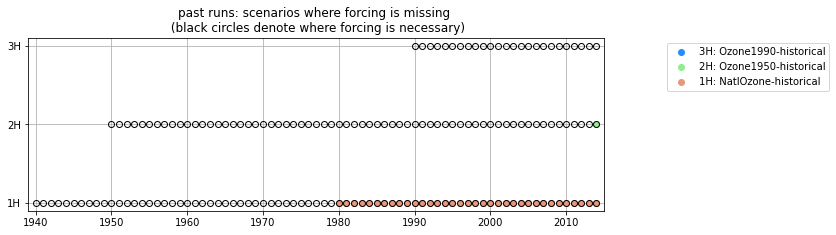

In [30]:
fig = plt.figure(figsize = (10, 3))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

yrsmissing_1H = np.arange(1980,2015,1)
yrsmissing_3H = []
tm = 'o'

plt.plot(yrsmissing_3H,np.ones_like(yrsmissing_3H)*3, color = col_3A, marker = tm, linestyle = '', label = name_3H)
plt.plot(yrsmissing_2H,np.ones_like(yrsmissing_2H)*2.0, color = col_2A, marker = tm, linestyle = '', label = name_2H)
plt.plot(yrsmissing_1H,np.ones_like(yrsmissing_1H)*1, color = col_1A, marker = tm, linestyle = '', label = name_1H)

yrnec_1H = np.arange(1940,2015,1)
plt.plot(yrnec_1H, np.ones_like(yrnec_1H), color = 'none', marker = 'o', markeredgecolor = 'k')
yrnec_2H = np.arange(1950,2015,1)
plt.plot(yrnec_2H, np.ones_like(yrnec_2H)*2, color = 'none', marker = 'o', markeredgecolor = 'k')
yrnec_3H = np.arange(1990,2015,1)
plt.plot(yrnec_3H, np.ones_like(yrnec_3H)*3, color = 'none', marker = 'o', markeredgecolor = 'k')


ax.legend(bbox_to_anchor = [1.1,1])
ax.grid()
ax.set_xlim([1939,2015])
ax.set_title('past runs: scenarios where forcing is missing \n (black circles denote where forcing is necessary)')
q = ax.set_yticks([1,2,3])
q = ax.set_yticklabels(['1H','2H','3H'])

Text(0.5, 1.0, 'future runs: scenarios where forcing is missing \n (black circles denote where forcing is necessary)')

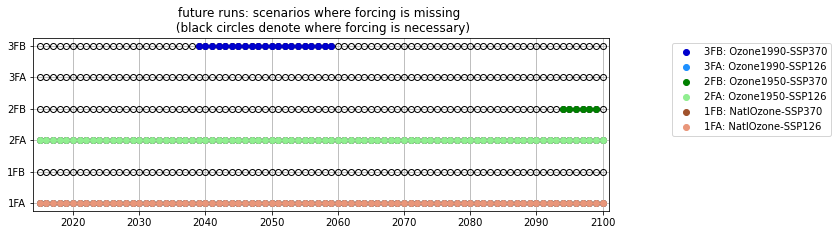

In [37]:
fig = plt.figure(figsize = (10, 3))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 

yrnec_future = np.arange(2015,2101,1)
plt.plot(yrnec_future, np.ones_like(yrnec_future), color = 'none', marker = 'o', markeredgecolor = 'k')
plt.plot(yrnec_future, np.ones_like(yrnec_future)*1.5, color = 'none', marker = 'o', markeredgecolor = 'k')
plt.plot(yrnec_future, np.ones_like(yrnec_future)*2, color = 'none', marker = 'o', markeredgecolor = 'k')
plt.plot(yrnec_future, np.ones_like(yrnec_future)*2.5, color = 'none', marker = 'o', markeredgecolor = 'k')
plt.plot(yrnec_future, np.ones_like(yrnec_future)*3, color = 'none', marker = 'o', markeredgecolor = 'k')
plt.plot(yrnec_future, np.ones_like(yrnec_future)*3.5, color = 'none', marker = 'o', markeredgecolor = 'k')


plt.plot(yrsmissing_3FB,np.ones_like(yrsmissing_3FB)*3.5, color = col_3B, marker = 'o', linestyle = '', label = name_3FB)
plt.plot(yrsmissing_3FA,np.ones_like(yrsmissing_3FA)*3, color = col_3A, marker = 'o', linestyle = '', label = name_3FA)

plt.plot(yrsmissing_2FB,np.ones_like(yrsmissing_2FB)*2.5, color = col_2B, marker = 'o', linestyle = '', label = name_2FB)
plt.plot(yrsmissing_2FA,np.ones_like(yrsmissing_2FA)*2.0, color = col_2A, marker = 'o', linestyle = '', label = name_2FA)

plt.plot(yrsmissing_1FB,np.ones_like(yrsmissing_1FB)*1.5, color = col_1B, marker = 'o', linestyle = '', label = name_1FB)
plt.plot(yrsmissing_1FA,np.ones_like(yrsmissing_1FA)*1, color = col_1A, marker = 'o', linestyle = '', label = name_1FA)

q = ax.set_yticks([1,1.5,2,2.5,3,3.5])
q = ax.set_yticklabels(['1FA','1FB','2FA','2FB','3FA','3FB'])
ax.legend(bbox_to_anchor = [1.1,1])
ax.grid()
ax.set_xlim([2014,2101])
ax.set_title('future runs: scenarios where forcing is missing \n (black circles denote where forcing is necessary)')


## files missing - numbers recap

In [11]:
scen = '1H'
tdir2 = dir_1H; desc = name_1H; misyr = yrsmissing_1H;
dirmis = dirmis_1H;

print(f'scenario {scen}, ({desc})')
print(f'directory address: {tdir}{tdir2}')
print(f'directory present: {dirmis}')
print('years with missing data:')
print(misyr); print()

scen = '2H'
tdir2 = dir_2H; desc = name_2H; misyr = yrsmissing_2H;
dirmis = dirmis_2H;

print(f'scenario {scen}, ({desc})')
print(f'directory address: {tdir}{tdir2}')
print(f'directory present: {dirmis}')
print('years with missing data:')
print(misyr); print()

scen = '3H'
tdir2 = dir_3H; desc = name_3H; misyr = yrsmissing_3H;
dirmis = dirmis_3H;

print(f'scenario {scen}, ({desc})')
print(f'directory address: {tdir}{tdir2}')
print(f'directory present: {dirmis}')
print('years with missing data:')
print(misyr); print()



scen = '1FA'
tdir2 = dir_1FA; desc = name_1FA; misyr = yrsmissing_1FA;
dirmis = dirmis_1FA;

print(f'scenario {scen}, ({desc})')
print(f'directory address: {tdir}{tdir2}')
print(f'directory present: {dirmis}')
print('years with missing data:')
print(misyr); print()

scen = '1FB'
tdir2 = dir_1FB; desc = name_1FB; misyr = yrsmissing_1FB;
dirmis = dirmis_1FB;

print(f'scenario {scen}, ({desc})')
print(f'directory address: {tdir}{tdir2}')
print(f'directory present: {dirmis}')
print('years with missing data:')
print(misyr); print()

scen = '2FA'
tdir2 = dir_2FA; desc = name_2FA; misyr = yrsmissing_2FA;
dirmis = dirmis_2FA;

print(f'scenario {scen}, ({desc})')
print(f'directory address: {tdir}{tdir2}')
print(f'directory present: {dirmis}')
print('years with missing data:')
print(misyr); print()

scen = '2FB'
tdir2 = dir_2FB; desc = name_2FB; misyr = yrsmissing_2FB;
dirmis = dirmis_2FB;

print(f'scenario {scen}, ({desc})')
print(f'directory address: {tdir}{tdir2}')
print(f'directory present: {dirmis}')
print('years with missing data:')
print(misyr); print()


scen = '3FA'
tdir2 = dir_3FA; desc = name_3FA; misyr = yrsmissing_3FA;
dirmis = dirmis_3FA;

print(f'scenario {scen}, ({desc})')
print(f'directory address: {tdir}{tdir2}')
print(f'directory present: {dirmis}')
print('years with missing data:')
print(misyr); print()

scen = '3FB'
tdir2 = dir_3FB; desc = name_3FB; misyr = yrsmissing_3FB;
dirmis = dirmis_3FB;

print(f'scenario {scen}, ({desc})')
print(f'directory address: {tdir}{tdir2}')
print(f'directory present: {dirmis}')
print('years with missing data:')
print(misyr); print()



scenario 1H, (1H: NatlOzone-historical)
directory address: /gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/
directory present: True
years with missing data:
[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014]

scenario 2H, (2H: Ozone1950-historical)
directory address: /gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-cj198_hist_1950start1950ozone/
directory present: True
years with missing data:
[2014]

scenario 3H, (3H: Ozone1990-historical)
directory address: /gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-cj200_hist_1990start1990ozone/
directory present: True
years with missing data:
[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989]

scenario 1FA, (1FA: NatlOzone-SSP126)
directory address: /gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/ssp126/u-be682_ssp126/
director